In [2]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros, asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import random
import os

Using TensorFlow backend.


In [3]:
class FruitsDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "apple")
        self.add_class("dataset", 2, "banana")
        self.add_class("dataset", 3, "orange")
        
        # Define data locations
        images_dir = dataset_dir + '/im/'
        annotations_dir = dataset_dir + '/ann/'
       
        for filename in listdir(images_dir):
            print(f"Processing file: {filename}")
            # Extract image id
            global image_id
            image_id = filename[:-4]
            print(f"Image ID: {image_id}")
            
            # Skip images based on the split
            if is_train and int(image_id) >= 55:
                continue
            if not is_train and int(image_id) < 60:
                continue

            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # Add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def extract_boxes(self, filename):
        # Load and parse the XML file
        tree = ElementTree.parse(filename)
        root = tree.getroot()
        boxes = []
        
        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):
        # Get details of the image
        info = self.image_info[image_id]
        path = info['annotation']
        
        # Load XML
        boxes, w, h = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = []

        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            
            # Use class names to populate masks
            class_name = box[4]
            if class_name == 'apple':
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('apple'))
            elif class_name == 'banana':
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('banana')) 
            elif class_name == 'orange':
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('orange'))

        return masks, asarray(class_ids, dtype='int32')
        
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

Processing file: 53.jpg
Image ID: 53
Processing file: 54.jpg
Image ID: 54
Processing file: 55.jpg
Image ID: 55
Processing file: 56.jpg
Image ID: 56
Processing file: 57.jpg
Image ID: 57
Processing file: 58.jpg
Image ID: 58
Processing file: 59.jpg
Image ID: 59
Processing file: 60.jpg
Image ID: 60
Train: 2
Processing file: 53.jpg
Image ID: 53
Processing file: 54.jpg
Image ID: 54
Processing file: 55.jpg
Image ID: 55
Processing file: 56.jpg
Image ID: 56
Processing file: 57.jpg
Image ID: 57
Processing file: 58.jpg
Image ID: 58
Processing file: 59.jpg
Image ID: 59
Processing file: 60.jpg
Image ID: 60
Test: 1


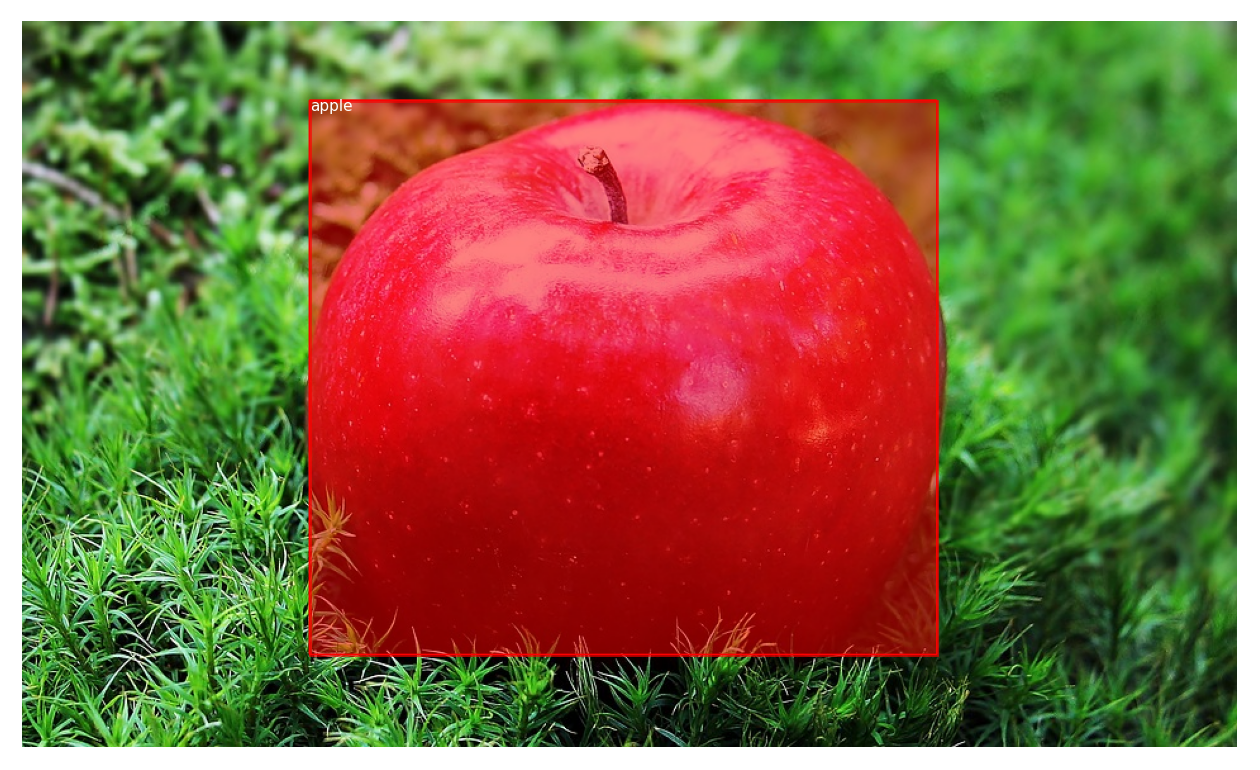

In [6]:
# Dataset directory
dataset_dir = r'C:\Users\ASUS VIVO\Desktop\Fruit_classification\datasets'

# Train set
train_set = FruitsDataset()
train_set.load_dataset(dataset_dir, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# Test set
test_set = FruitsDataset()
test_set.load_dataset(dataset_dir, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

# Display a random train image with masks
if len(train_set.image_ids) > 0:
    num = random.randint(0, len(train_set.image_ids))
    image_id = train_set.image_ids[num]
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    bbox = extract_bboxes(mask)
    display_instances(image, bbox, mask, class_ids, train_set.class_names)
else:
    print("No images found in the training set.")

In [ ]:

# Define configuration for the model
class FruitsConfig(Config):
    NAME = "fruits_cfg"
    NUM_CLASSES = 1 + 3  # Background + 3 fruits
    STEPS_PER_EPOCH = 1

# Prepare config
config = FruitsConfig()
config.display()

# Define the model
model = MaskRCNN(mode='training', model_dir="logs", config=config)
# Load weights (mscoco) and exclude the output layers
model.load_weights("weights/mask_rcnn_coco.h5", by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

# Train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')
model.keras_model.save_weights(model_path)

# Inference configuration
class PredictionConfig(Config):
    NAME = "fruits_cfg"
    NUM_CLASSES = 1 + 3  # Background + 3 fruits
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# Create prediction config
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='logs', config=cfg)
model.load_weights(r'C:\Users\ASUS VIVO\Desktop\Fruit_classification\logs\mask_rcnn_fruits_cfg_0020.h5', by_name=True)





Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

c:\Users\ASUS VIVO\.conda\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
